In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [3]:
from scipy.spatial.transform import Rotation

In [4]:
import torch
import sys
sys.path.append('/home/kirill/TopoSLAM/OpenPlaceRecognition/src')
from opr.pipelines.registration.pointcloud import RansacGlobalRegistrationPipeline
import open3d as o3d
import open3d.pipelines.registration as registration
from scipy.spatial.transform import Rotation
from icp import icp
ransac_registration_pipeline = RansacGlobalRegistrationPipeline(voxel_downsample_size=0.5)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [43]:
test_data = []
for ii in range(127):
    test_dir = '../test_registration_minkloc/test_{}'.format(ii)
    #cand_clouds = {}
    #ref_cloud = np.loadtxt(os.path.join(test_dir, 'ref_cloud.txt'))
    #cand_cloud_files = [fn for fn in os.listdir(test_dir) if fn.startswith('cand_cloud')]
    #cand_cloud_files = [fn for fn in cand_cloud_files if int(fn[11:-4]) >= 0]
    #for fn in cand_cloud_files:
    #    cloud = np.loadtxt(os.path.join(test_dir, fn))
    #    cand_clouds[int(fn[11:-4])] = cloud
    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
    gt_pose_shift = {}
    transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]
    transforms = {}
    pr_scores = np.loadtxt(os.path.join(test_dir, 'pr_scores.txt'))
    reg_scores = np.loadtxt(os.path.join(test_dir, 'reg_scores.txt'))
    for i in range(transforms_.size // 7):
        idx = transforms_[i, 0]
        pr_score = pr_scores[i]
        reg_score = reg_scores[i]
        transforms[idx] = transforms_[i, 1:]
        gt_pose_shift[idx] = gt_poses[i + 1] - gt_poses[0]
        dist = np.sqrt(gt_pose_shift[idx][0] ** 2 + gt_pose_shift[idx][1] ** 2)
        test_data.append([dist, pr_score, reg_score])
    #transforms = {}
    #for idx in cand_clouds.keys():
    #    transform = np.loadtxt(os.path.join(test_dir, 'transform_icp_{}.txt'.format(idx)))
    #    transforms[idx] = transform
    #transforms = np.array(transforms)
    #if transforms.ndim == 1:
    #    transforms = transforms[np.newaxis, :]
test_data = np.array(test_data)

/tmp/ipykernel_44710/2119625542.py:13: UserWarning: loadtxt: input contained no data: "../test_registration_minkloc/test_0/transforms.txt"
  transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))


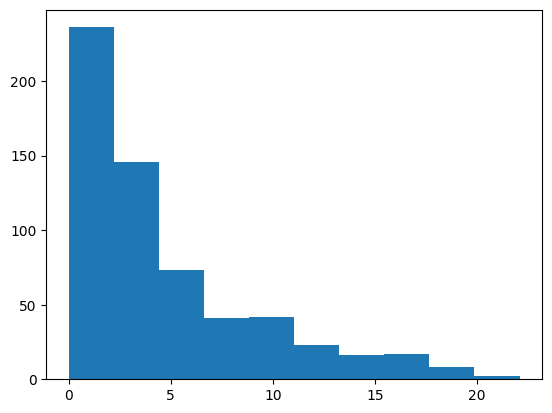

In [44]:
_ = plt.hist(test_data[:, 0])

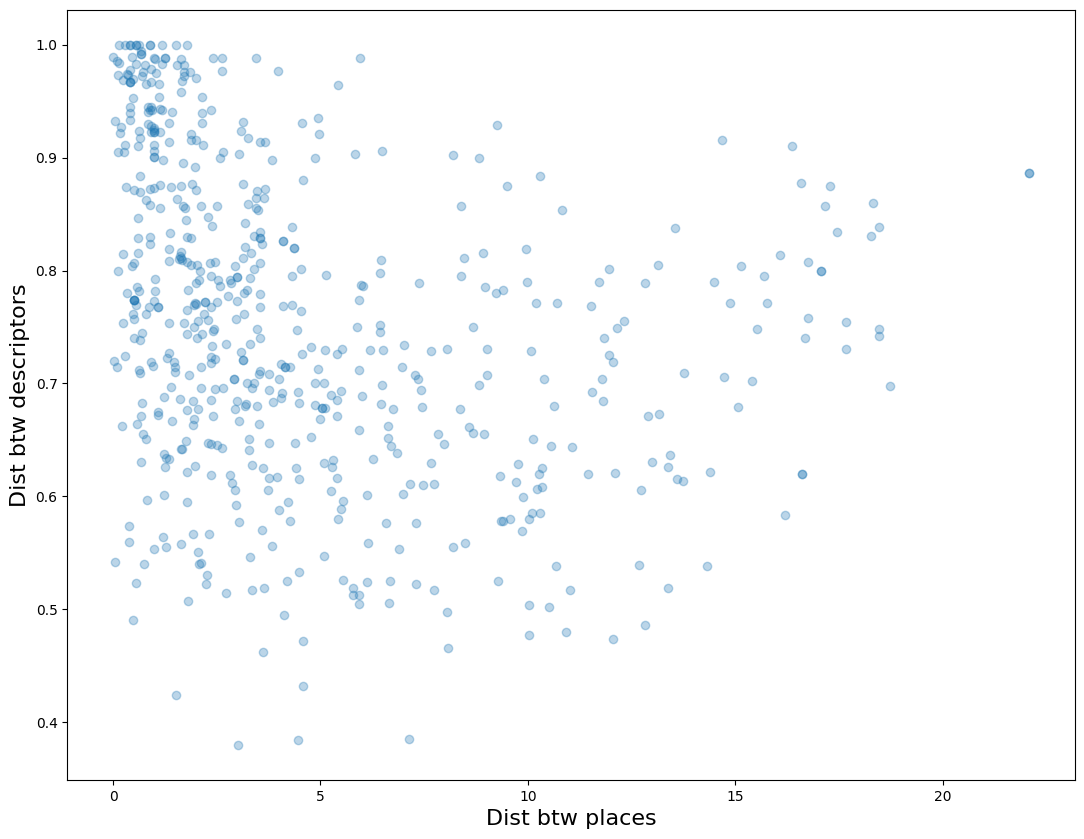

In [45]:
plt.figure(figsize=(13, 10))
test_data_matched = test_data[test_data[:, 2] > 0.]
plt.scatter(test_data_matched[:, 0], test_data_matched[:, 2], alpha=0.3)
plt.xlabel('Dist btw places', fontsize=16)
plt.ylabel('Dist btw descriptors', fontsize=16)
plt.savefig('pr_descriptor_distance.png')

In [46]:
gt_pose_shift

{143.0: array([-0.09986734,  0.38766623, -0.10471983]),
 178.0: array([ 0.12516363,  0.99070108, -0.1570797 ]),
 141.0: array([ 2.447271  ,  2.55055123, -1.0995574 ]),
 142.0: array([ 0.85692739,  2.2022815 , -0.89011788]),
 144.0: array([-0.01601296,  0.51198151,  2.61799395])}

## Регистрация облаков точек

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
from iou import get_iou, transform_pcd
from opr.pipelines.registration.pointcloud import Feature2DGlobalRegistrationPipeline
import time

In [105]:
def get_pose_shift(pose1, pose2):
    x1, y1, angle1 = pose1
    x2, y2, angle2 = pose2
    dangle = angle1 - angle2
    dx = (x2 - x1) * np.cos(angle1) + (y2 - y1) * np.sin(angle1)
    dy = - (x2 - x1) * np.sin(angle1) + (y2 - y1) * np.cos(angle1)
    return np.array([dx, dy, dangle])

In [106]:
def transform_icp(ref_cloud, cand_cloud, ransac_transform):
    threshold = 0.3
    ref_cloud_o3d = o3d.geometry.PointCloud()
    cand_cloud_o3d = o3d.geometry.PointCloud()
    ref_cloud_o3d.points = o3d.utility.Vector3dVector(ref_cloud[:, :3])
    cand_cloud_o3d.points = o3d.utility.Vector3dVector(cand_cloud[:, :3])
    ref_cloud_o3d = ref_cloud_o3d.voxel_down_sample(0.2)
    cand_cloud_o3d = cand_cloud_o3d.voxel_down_sample(0.2)
    reg_p2p = registration.registration_icp(ref_cloud_o3d, cand_cloud_o3d, threshold, ransac_transform,
            registration.TransformationEstimationPointToPoint(),
            registration.ICPConvergenceCriteria(max_iteration = 500))
    tf_matrix = reg_p2p.transformation.copy()
    tf_rotation = Rotation.from_matrix(tf_matrix[:3, :3]).as_rotvec()
    tf_rotation[:2] = 0
    r = Rotation.from_rotvec(tf_rotation).as_matrix()
    tf_matrix[:3, :3] = r
    tf_translation = tf_matrix[:3, 3]
    return tf_matrix, reg_p2p.fitness

In [107]:
def normalize(angle):
    while angle > np.pi:
        angle -= 2 * np.pi
    while angle < -np.pi:
        angle += 2 * np.pi
    return angle

def transformation_error(gt_pose_shift, tf_matrix_estimated):
    tf_rotation = Rotation.from_matrix(tf_matrix_estimated[:3, :3]).as_rotvec()
    gt_x, gt_y, gt_angle = gt_pose_shift
    gt_angle = -gt_angle
    estimated_angle = tf_rotation[2]
    estimated_x = tf_matrix_estimated[0, 3]
    estimated_y = tf_matrix_estimated[1, 3]
    return (np.abs(estimated_x - gt_x), np.abs(estimated_y - gt_y), np.abs(normalize(estimated_angle - gt_angle)))

In [108]:
pipeline_sift = Feature2DGlobalRegistrationPipeline(detector_type='SIFT')
pipeline_orb = Feature2DGlobalRegistrationPipeline(detector_type='ORB')

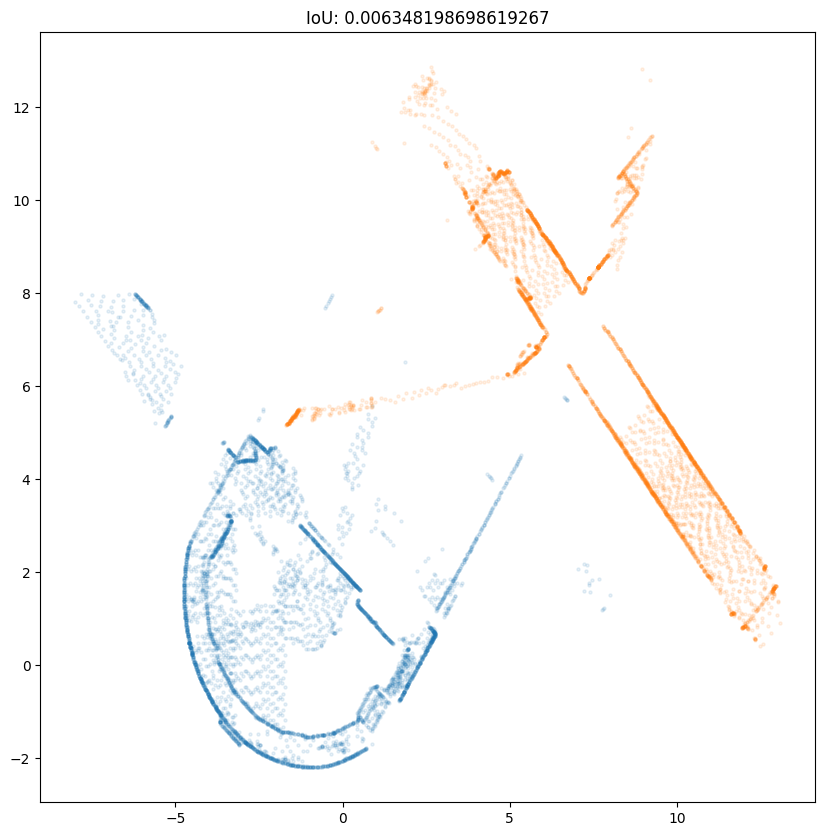

In [109]:
plt.figure(figsize=(10, 10))
ref_cloud_transformed = transform_pcd(ref_cloud, gt_poses[0, 0], gt_poses[0, 1], -gt_poses[0, 2])
rel_x, rel_y, rel_theta = gt_pose_shift[idx]
#cloud_transformed = transform_pcd(cloud, -gt_poses[i + 1, 0], -gt_poses[i + 1, 1], -gt_poses[i + 1, 2])
cloud_transformed = transform_pcd(cloud, rel_x, rel_y, rel_theta)
plt.title('IoU: {}'.format(iou))
plt.scatter(ref_cloud[::7, 0], ref_cloud[::7, 1], s=5, alpha=0.1)
#plt.scatter(ref_cloud_transformed[::7, 0], ref_cloud_transformed[::7, 1], s=5, alpha=0.1)
plt.scatter(cloud_transformed[::7, 0], cloud_transformed[::7, 1], s=5, alpha=0.1)
plt.show()

/tmp/ipykernel_44710/1010401277.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for ii in tqdm_notebook(np.arange(50)):


  0%|          | 0/50 [00:00<?, ?it/s]

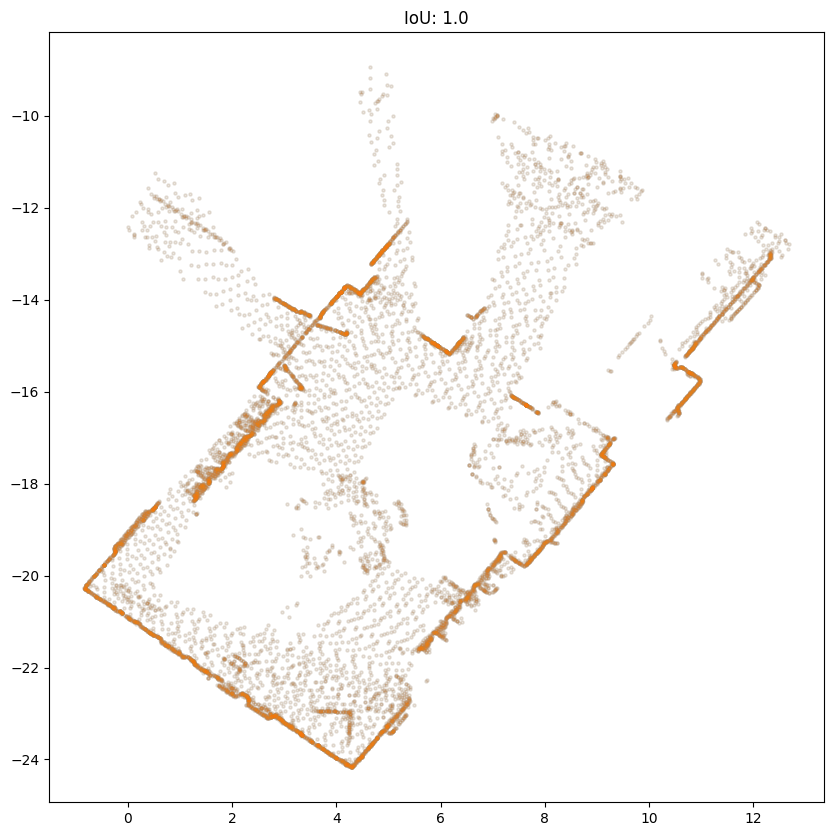

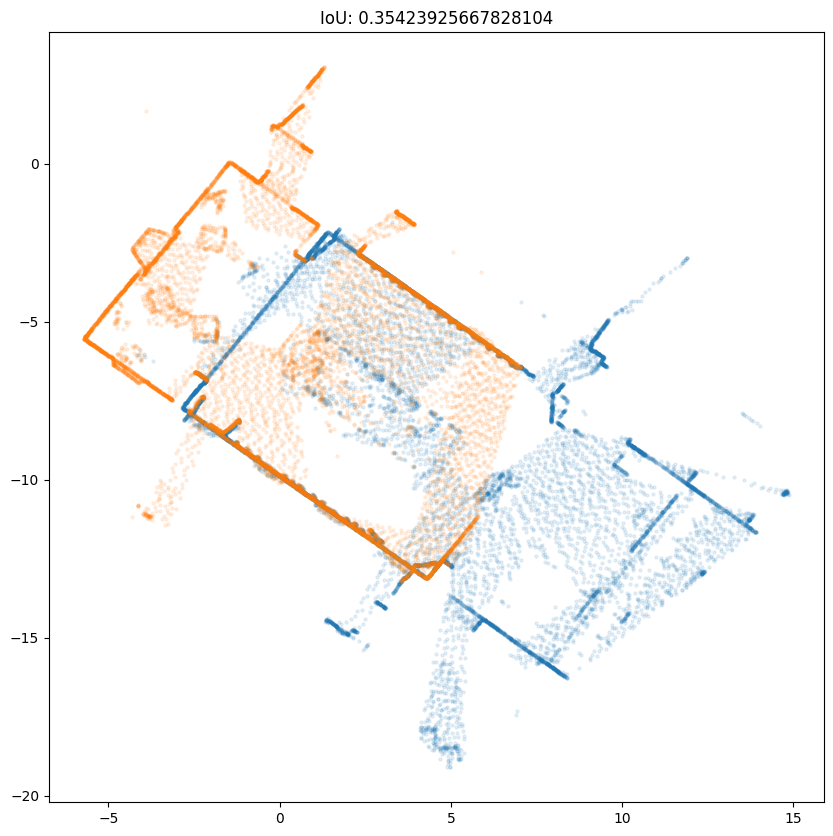

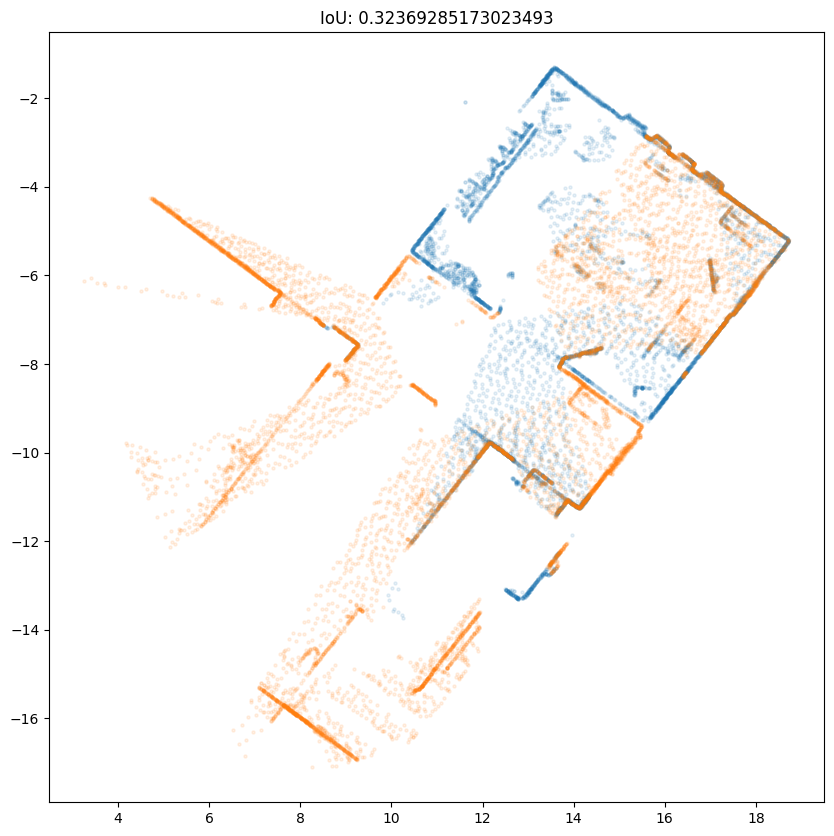

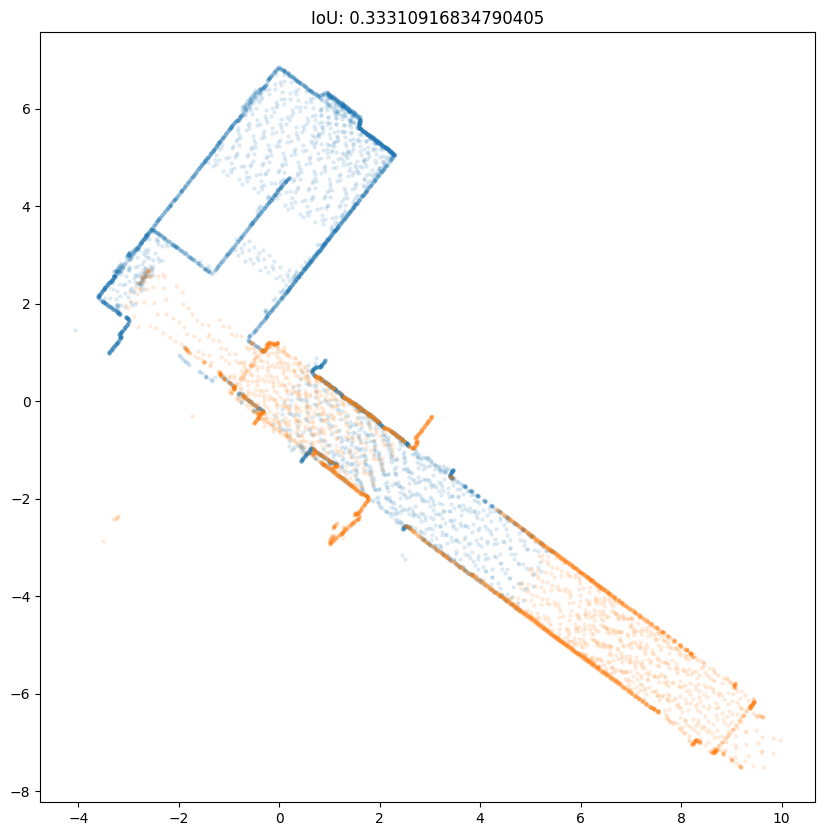

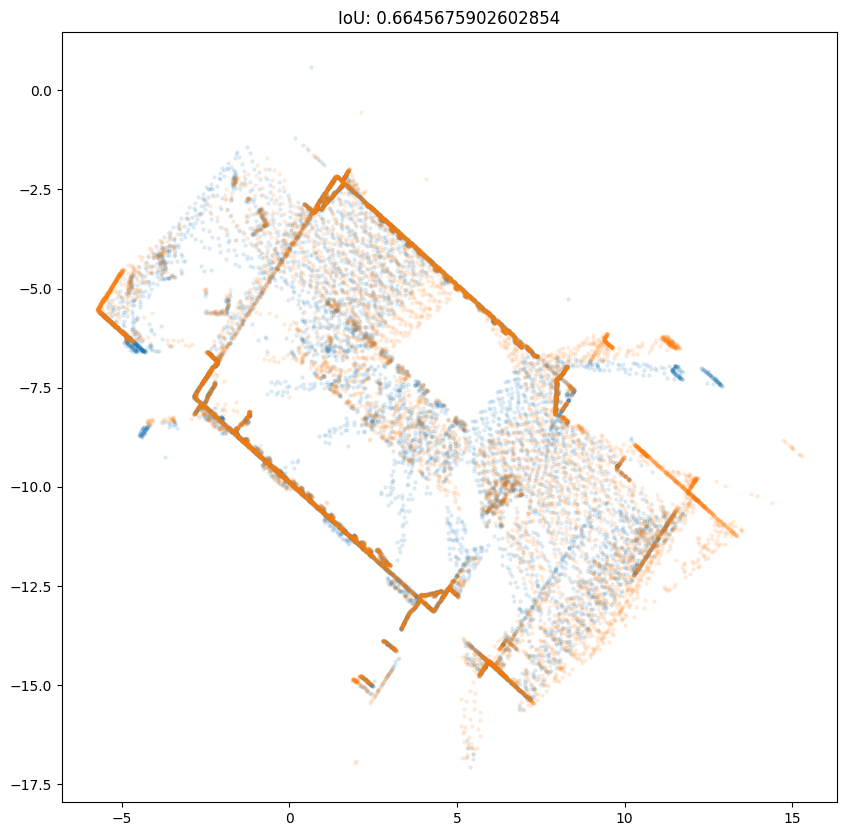

In [112]:
test_results = []
ious = []
dists = []
#icp_results = []
#sift_results = []
#orb_results = []
geotransformer_results = []
#icp_times = []
#sift_times = []
#orb_times = []
geotransformer_times = []
for ii in tqdm_notebook(np.arange(50)):
    test_dir = '../test_registration/test_{}'.format(ii)
    cand_clouds = {}
    ref_cloud = np.loadtxt(os.path.join(test_dir, 'ref_cloud.txt'))
    ref_cloud = ref_cloud[:, :3]
    cand_cloud_files = [fn for fn in os.listdir(test_dir) if fn.startswith('cand_cloud')]
    cand_cloud_files = [fn for fn in cand_cloud_files if int(fn[11:-4]) >= 0]
    for fn in cand_cloud_files:
        cloud = np.loadtxt(os.path.join(test_dir, fn))
        cand_clouds[int(fn[11:-4])] = cloud
    gt_poses = np.loadtxt(os.path.join(test_dir, 'gt_poses.txt'))
    gt_pose_shift = {}
    transforms_ = np.loadtxt(os.path.join(test_dir, 'transforms.txt'))
    if transforms_.ndim == 1:
        transforms_ = transforms_[np.newaxis, :]
    transforms = {}
    pr_scores = np.loadtxt(os.path.join(test_dir, 'pr_scores.txt'))
    reg_scores = np.loadtxt(os.path.join(test_dir, 'reg_scores.txt'))
    for i in range(transforms_.size // 7):
        idx = transforms_[i, 0]
        pr_score = pr_scores[i]
        reg_score = reg_scores[i]
        transforms[idx] = transforms_[i, 1:]
        gt_pose_shift[idx] = get_pose_shift(gt_poses[i + 1], gt_poses[0])
        dist = np.sqrt(gt_pose_shift[idx][0] ** 2 + gt_pose_shift[idx][1] ** 2)
        cloud = cand_clouds[idx][:, :3]
        
        """
        rotation_ransac = np.array([0, 0, transforms[idx][2]])
        translation_ransac = np.array([transforms[idx][3], transforms[idx][4], 0])
        r = Rotation.from_rotvec(rotation_ransac).as_matrix()
        tf_matrix = np.zeros((4, 4))
        tf_matrix[:3, :3] = r
        tf_matrix[:3, 3] = translation_ransac
        tf_matrix[3] = [0, 0, 0, 1]
        cloud = cand_clouds[idx][:, :3]
        start_time = time.time()
        tf_matrix_icp, fitness_icp = transform_icp(ref_cloud, cloud, tf_matrix)
        icp_times.append(time.time() - start_time)
        rotation_icp = Rotation.from_matrix(tf_matrix_icp[:3, :3]).as_rotvec()
        translation_icp = tf_matrix_icp[:3, 3].copy()
        error_icp = transformation_error(gt_pose_shift[idx], tf_matrix_icp)
        
        ref_cloud_tensor = torch.Tensor(ref_cloud)
        cand_cloud_tensor = torch.Tensor(cloud)
        start_time = time.time()
        tf_matrix_sift, fitness_sift = pipeline_sift.infer(ref_cloud_tensor, cand_cloud_tensor)
        sift_times.append(time.time() - start_time)
        start_time = time.time()
        tf_matrix_orb, fitness_orb = pipeline_orb.infer(ref_cloud_tensor, cand_cloud_tensor)
        orb_times.append(time.time() - start_time)
        if tf_matrix_sift is not None:
            error_sift = transformation_error(gt_pose_shift[idx], tf_matrix_sift)
        else:
            error_sift = None
        if tf_matrix_orb is not None:
            error_orb = transformation_error(gt_pose_shift[idx], tf_matrix_orb)
        else:
            error_orb = None
        """
        
        ref_cloud_tensor = torch.Tensor(ref_cloud)
        cand_cloud_tensor = torch.Tensor(cloud)
        start_time = time.time()
        try:
            tf_matrix = geotransformer_pipeline.infer(ref_cloud_tensor, cand_cloud_tensor)
        except:
            tf_matrix = None
        geotransformer_times.append(time.time() - start_time)
        if tf_matrix is not None:
            error_geotransformer = transformation_error(gt_pose_shift[idx], tf_matrix)
        else:
            error_geotransformer = None
        
        iou = get_iou(*-gt_pose_shift[idx], ref_cloud, cloud)
        dist = np.sqrt(gt_pose_shift[idx][0] ** 2 + gt_pose_shift[idx][1] ** 2)
        ious.append(iou)
        dists.append(dist)
        #icp_results.append((fitness_icp, error_icp))
        #sift_results.append((fitness_sift, error_sift))
        #orb_results.append((fitness_orb, error_orb))
        geotransformer_results.append(error_geotransformer)
    if ii % 10 == 0:  
        plt.figure(figsize=(10, 10))
        ref_cloud_transformed = transform_pcd(ref_cloud, gt_poses[0, 0], gt_poses[0, 1], -gt_poses[0, 2])
        cloud_transformed = transform_pcd(cloud, gt_poses[i + 1, 0], gt_poses[i + 1, 1], -gt_poses[i + 1, 2])
        plt.title('IoU: {}'.format(iou))
        plt.scatter(ref_cloud_transformed[::7, 0], ref_cloud_transformed[::7, 1], s=5, alpha=0.1)
        plt.scatter(cloud_transformed[::7, 0], cloud_transformed[::7, 1], s=5, alpha=0.1)
        plt.show()

### Test set properties

In [111]:
print('Total number of pairs:', len(ious))
print('Number of pairs with IoU > 0.5:', sum([i > 0.5 for i in ious]))
print('Number of pairs with IoU > 0.25:', sum([i > 0.25 for i in ious]))
print('Number of pairs closer than 5 m:', sum([i < 5 for i in dists]))
print('Number of pairs further than 10 m:', sum([i > 10 for i in dists]))

Total number of pairs: 242
Number of pairs with IoU > 0.5: 10
Number of pairs with IoU > 0.25: 103
Number of pairs closer than 5 m: 145
Number of pairs further than 10 m: 31


### ICP results

In [16]:
print('Average runtime:', np.mean(icp_times))

Average runtime: 0.08361149031268664


In [80]:
print('Number of correct matches with IoU > 0.5:', np.sum([(icp_results[i][0] > 0.8) * (max(icp_results[i][1]) < 0.5) \
                                              for i in range(len(ious)) if ious[i] > 0.25]))
print('Number of wrong matches:', np.sum([(fitness > 0.8) * (max(error) > 0.5) \
                                              for fitness, error in icp_results]))
print('Number of missed matches with IoU > 0.5:', np.sum([(icp_results[i][0] < 0.8) * (ious[i] > 0.5) \
                                                          for i in range(len(ious))]))
print('Number of missed matches with IoU > 0.25:', np.sum([(icp_results[i][0] < 0.8) * (ious[i] > 0.25) \
                                                          for i in range(len(ious))]))

Number of correct matches with IoU > 0.5: 30
Number of wrong matches: 6
Number of missed matches with IoU > 0.5: 26
Number of missed matches with IoU > 0.25: 117


In [82]:
6 / 153

0.0392156862745098

### SIFT results

In [18]:
print('Average runtime:', np.mean(sift_times))

Average runtime: 0.06465172373558864


In [22]:
print('Number of correct matches:', np.sum([(fitness > 0.) * (max(error) < 0.5) \
                                              for fitness, error in sift_results if fitness > 0.5]))
print('Number of wrong matches:', np.sum([(fitness > 0.) * (max(error) > 0.5) \
                                              for fitness, error in sift_results if fitness > 0.5]))
print('Number of missed matches with IoU > 0.5:', np.sum([(sift_results[i][0] < 0.5) * (ious[i] > 0.5) \
                                                          for i in range(len(ious))]))
print('Number of missed matches with IoU > 0.25:', np.sum([(sift_results[i][0] < 0.5) * (ious[i] > 0.25) \
                                                          for i in range(len(ious))]))
print('Number of missed matches with IoU between 0.25 and 0.5:', np.sum([(sift_results[i][0] < 0.5) * \
                                                                         (ious[i] > 0.25) * (ious[i] < 0.5) \
                                                          for i in range(len(ious))]))

Number of correct matches: 51
Number of wrong matches: 2
Number of missed matches with IoU > 0.5: 16
Number of missed matches with IoU > 0.25: 100
Number of missed matches with IoU between 0.25 and 0.5: 84


### ORB results

In [595]:
print('Average runtime:', np.mean(orb_times))

Average runtime: 0.028819483811738062


In [607]:
print('Number of correct matches:', np.sum([(fitness > 0.) * (max(error) < 0.5) \
                                              for fitness, error in orb_results if fitness is not None]))
print('Number of wrong matches:', np.sum([(fitness > 0.) * (max(error) > 0.5) \
                                              for fitness, error in orb_results if fitness is not None]))
print('Number of missed matches with IoU > 0.5:', np.sum([(orb_results[i][0] is None) * (ious[i] > 0.5) \
                                                          for i in range(len(ious))]))
print('Number of missed matches with IoU > 0.25:', np.sum([(orb_results[i][0] is None) * (ious[i] > 0.25) \
                                                          for i in range(len(ious))]))

Number of correct matches: 58
Number of wrong matches: 0
Number of missed matches with IoU > 0.5: 10
Number of missed matches with IoU > 0.25: 100


In [615]:
6 / 244

0.02459016393442623

### Geotransformer results

In [32]:
from hydra.utils import instantiate
from omegaconf import OmegaConf
from opr.pipelines.registration import PointcloudRegistrationPipeline

In [55]:
REGISTRATION_MODEL_CONFIG_PATH = "/home/kirill/TopoSLAM/OpenPlaceRecognition/configs/model/registration/geotransformer_kitti.yaml"
REGISTRATION_WEIGHTS_PATH = "/home/kirill/TopoSLAM/OpenPlaceRecognition/weights/registration/geotransformer_kitti.pth"
registration_model = instantiate(OmegaConf.load(REGISTRATION_MODEL_CONFIG_PATH))
registration_model.load_state_dict(torch.load(REGISTRATION_WEIGHTS_PATH))
geotransformer_pipeline = PointcloudRegistrationPipeline(
                                model=registration_model,
                                model_weights_path=REGISTRATION_WEIGHTS_PATH,
                                device="cuda",  # the GeoTransformer currently only supports CUDA
                                voxel_downsample_size=0.3,  # recommended for geotransformer_kitti configuration
                            )
registration_score_threshold = 0.8

In [60]:
print('Average runtime:', np.mean(geotransformer_times))

Average runtime: 0.2783751596104015


In [113]:
geotransformer_results_numpy = []
for x in geotransformer_results:
    if x is None:
        geotransformer_results_numpy.append([100, 190, 230])
    else:
        geotransformer_results_numpy.append(list(x))
geotransformer_results_numpy = np.array(geotransformer_results_numpy)
error_value = np.sqrt(np.sum(geotransformer_results_numpy ** 2, axis=1))

In [114]:
(error_value < 0.5).mean()

0.4380165289256198

In [126]:
print('Number of correct matches:', np.sum([(error_value < 0.1) * (np.array(ious) > 0.5)]))
print('Number of wrong matches:', np.sum([(error_value > 0.1)]))
print('Number of missed matches with IoU > 0.5:', np.sum([(error_value[i] > 0.2) * (ious[i] > 0.5) \
                                                          for i in range(len(ious))]))
print('Number of missed matches with IoU > 0.25:', np.sum([(orb_results[i][0] is None) * (ious[i] > 0.25) \
                                                          for i in range(len(ious))]))

Number of correct matches: 40
Number of wrong matches: 171
Number of missed matches with IoU > 0.5: 11
Number of missed matches with IoU > 0.25: 0


In [96]:
106 / 153

0.6928104575163399

## Сопоставление 2D проекций облаков с помощью OpenCV

In [16]:
%load_ext autoreload
%autoreload 2

In [24]:
import cv2
from skimage.transform import rotate
from opencv_feature_matching import transform_from_2d_feat, remove_floor_and_ceil

In [25]:
def pcd_to_img(cloud, grid_size=0.05):
    cloud_cropped = remove_floor_and_ceil(cloud)[:, :2]
    points = cloud_cropped[(np.abs(cloud_cropped[:, 0]) < 8) * (np.abs(cloud_cropped[:, 1] < 8))]
    grid = np.zeros((int(16 / grid_size) + 1, int(16 / grid_size) + 1))
    points_int = ((points + [8, 8]) / grid_size).astype(np.int32)
    grid[points_int[:, 0], points_int[:, 1]] = 1
    return grid

In [26]:
def transform_from_2d_feat(ref_cloud, cand_cloud):
    # Convert clouds to images
    img_ref = pcd_to_img(ref_cloud)
    img_ref = (img_ref * 255).astype(np.uint8)
    img_cand = pcd_to_img(cand_cloud)
    img_cand = (img_cand * 255).astype(np.uint8)
    
    # Extract features
    sift = cv2.ORB_create()
    #sift = cv2.SIFT_create(400)
    kp_ref, des_ref = sift.detectAndCompute(img_ref, None)
    kp_cand, des_cand = sift.detectAndCompute(img_cand, None)
    
    # Match features using KNN
    #FLANN_INDEX_KDTREE = 1
    #index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    FLANN_INDEX_LSH = 6
    index_params= dict(algorithm = FLANN_INDEX_LSH,
                       table_number = 6, # 12
                       key_size = 12,     # 20
                       multi_probe_level = 1) #2
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des_ref, des_cand, k=2)
    matches = [x for x in matches if len(x) == 2]
    
    # Get 2d point sets from matched features
    good = []
    for i,(m,n) in enumerate(matches):
        
        if m.distance < 0.7 * n.distance:
            good.append(m)
    src_pts = np.float32([ kp_ref[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_cand[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    # Remove outliers
    threshold = 10
    for i in range(3):
        if len(src_pts) < 5:
            print('Unable to find transform: too few matches!')
            return None
        point_pairs = np.concatenate([src_pts, dst_pts], axis=1)
        rot_angle, trans_x, trans_y = point_based_matching(point_pairs)
        src_transformed = src_pts[:, 0, :].copy()
        src_transformed[:, 0] = src_pts[:, 0, 0] * np.cos(-rot_angle) + src_pts[:, 0, 1] * np.sin(-rot_angle) + trans_x
        src_transformed[:, 1] = -src_pts[:, 0, 0] * np.sin(-rot_angle) + src_pts[:, 0, 1] * np.cos(-rot_angle) + trans_y
        matching_error = np.sqrt((src_transformed[:, 0] - dst_pts[:, 0, 0]) ** 2 + (src_transformed[:, 1] - dst_pts[:, 0, 1]) ** 2)
        print(matching_error)
        if matching_error.max() < threshold:
            break
            #threshold = matching_error.max() - 1e-4
        print('Number of outliers:', (matching_error > threshold).sum())
        src_pts = src_pts[matching_error < threshold]
        dst_pts = dst_pts[matching_error < threshold]
    
    # Calculate transformation matrix for input point clouds
    plus8 = np.eye(4)
    plus8[0, 3] = 8
    plus8[1, 3] = 8
    minus8 = np.eye(4)
    minus8[0, 3] = -8
    minus8[1, 3] = -8
    tf_matrix = np.array([
        [np.cos(rot_angle), np.sin(rot_angle), 0, trans_y * 0.05],
        [-np.sin(rot_angle), np.cos(rot_angle), 0, trans_x * 0.05],
        [0,                  0,                 1, 0],
        [0,                  0,                 0, 1]
    ])
    return minus8 @ tf_matrix @ plus8

## Test IoU

In [7]:
from skimage.io import imread

In [8]:
def transform_pcd(points, x, y, theta):
    points_transformed = points.copy()
    points_transformed[:, 0] = points[:, 0] * np.cos(theta) + points[:, 1] * np.sin(theta)
    points_transformed[:, 1] = -points[:, 0] * np.sin(theta) + points[:, 1] * np.cos(theta)
    points_transformed[:, 0] += x
    points_transformed[:, 1] += y
    return points_transformed

In [9]:
def normalize(angle):
        while angle < -np.pi:
            angle += 2 * np.pi
        while angle > np.pi:
            angle -= 2 * np.pi
        return angle

def rotate(x, y, angle):
    x_new = x * np.cos(angle) + y * np.sin(angle)
    y_new = -x * np.sin(angle) + y * np.cos(angle)
    return x_new, y_new

def get_rel_pose(x, y, theta, x2, y2, theta2):
    #print('x, y, theta:', x, y, theta)
    #print('x2 y2 theta2:', x2, y2, theta2)
    rel_x, rel_y = rotate(x2 - x, y2 - y, theta2)
    #print('Rel x, rel y: rel theta:', rel_x, rel_y, theta2 - theta)
    #angle = self.normalize(np.arctan2(y2 - y, x2 - x) - theta)
    return [-rel_x, -rel_y, normalize(theta2 - theta)]

In [10]:
from IPython.display import clear_output
from time import sleep
from skimage.transform import rotate as image_rotate

In [11]:
def get_occupancy_grid(points_xyz):
        points_xyz = np.clip(points_xyz, -8, 8)
        resolution = 0.1
        radius = 18
        points_ij = np.round(points_xyz[:, :2] / resolution).astype(int) + [int(radius / resolution), int(radius / resolution)]
        grid = np.zeros((int(2 * radius / resolution), int(2 * radius / resolution)), dtype=np.uint8)
        grid[points_ij[:, 0], points_ij[:, 1]] = 1
        return grid

def get_iou(rel_x, rel_y, rel_theta, cur_cloud, v_cloud):
    #print('Rel x rel y rel theta:', rel_x, rel_y, rel_theta)
    cur_cloud = cur_cloud[cur_cloud[:, 2] > -0.7]
    v_cloud = v_cloud[v_cloud[:, 2] > -0.7]
    cur_cloud_transformed = transform_pcd(cur_cloud, rel_x, rel_y, rel_theta)
    cur_grid_transformed = get_occupancy_grid(cur_cloud_transformed)
    quadrat = np.zeros_like(cur_grid_transformed)
    quadrat[163:198, 163:198] = 1
    quadrat = image_rotate(quadrat, rel_theta * 180 / np.pi) * 255.
    cur_grid_transformed[156 + int(rel_x * 10):205 + int(rel_x * 10), 
                        156 + int(rel_y * 10):205 + int(rel_y * 10)] = np.maximum(cur_grid_transformed[156 + int(rel_x * 10):205 + int(rel_x * 10), 
                                                                                156 + int(rel_y * 10):205 + int(rel_y * 10)],
                                                                                quadrat[156:205, 156:205])
    v_grid = get_occupancy_grid(v_cloud)
    v_grid[163:198, 163:198] = 1
    intersection = np.sum(v_grid * cur_grid_transformed)
    union = np.sum(v_grid | cur_grid_transformed)
    grid_aligned = np.zeros((v_grid.shape[0], v_grid.shape[1], 3))
    grid_aligned[:, :, 0] = cur_grid_transformed
    grid_aligned[:, :, 1] = v_grid
    grid_aligned = (grid_aligned * 255).astype(np.uint8)
    return intersection / union

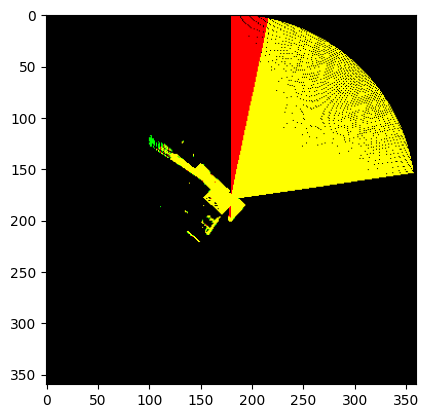

In [13]:
plt.imshow(align_img)

Rel pose: [-7.99999628e-01 -3.85900536e-07 -8.72663856e-02]


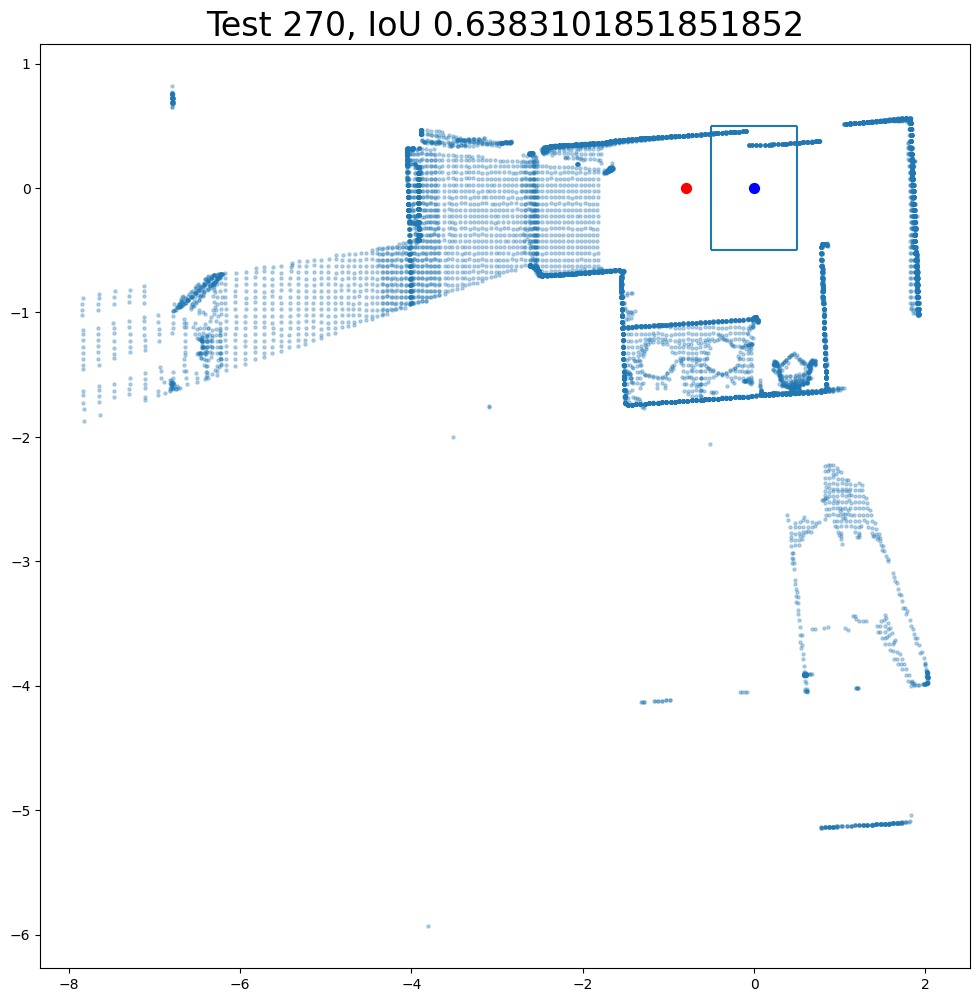

In [37]:
for i in range(270, 271):
    data_dir = '/home/kirill/test_iou/{}'.format(i)
    cur_cloud = np.load(os.path.join(data_dir, 'cur_cloud.npz'))['arr_0']
    v_cloud = np.load(os.path.join(data_dir, 'v_cloud.npz'))['arr_0']
    cur_cloud_transformed = np.load(os.path.join(data_dir, 'cur_cloud_transformed.npz'))['arr_0']
    #cur_pose = np.loadtxt(os.path.join(data_dir, 'cur_pose.txt'))
    #v_pose = np.loadtxt(os.path.join(data_dir, 'v_pose.txt'))
    rel_pose = np.loadtxt(os.path.join(data_dir, 'rel_pose.txt'))
    align_img = imread(os.path.join(data_dir, 'grid_aligned.png'))
    #print('Cur pose:', cur_pose)
    #print('V pose:', v_pose)
    #rel_pose = get_rel_pose(*cur_pose, *v_pose)
    print('Rel pose:', rel_pose)
    #rel_pose[0] *= -1
    #rel_pose[1] *= -1
    #rel_pose_rotated = rel_pose.copy()
    #rel_pose_rotated[0] = -rel_pose[0] * np.cos(rel_pose[2]) - rel_pose[1] * np.sin(rel_pose[2])
    #rel_pose_rotated[1] = rel_pose[0] * np.sin(rel_pose[2]) - rel_pose[1] * np.cos(rel_pose[2])
    #print('Rel pose rotated:', rel_pose_rotated)
    #cur_cloud_transformed = transform_pcd(cur_cloud, *rel_pose)
    
    fig = plt.figure(figsize=(12, 12))
    iou = get_iou(*rel_pose, cur_cloud, v_cloud)
    plt.title('Test {}, IoU {}'.format(i, iou), fontsize=24)
    plt.scatter(v_cloud[:, 0], v_cloud[:, 1], s=5, alpha=0.3)
    #plt.scatter(cur_cloud_transformed[:, 0], cur_cloud_transformed[:, 1], s=5, alpha=0.3)
    plt.scatter([rel_pose[0]], [rel_pose[1]], color='r', s=50)
    plt.scatter([0], [0], color='b', s=50)
    plt.hlines(0.5, -0.5, 0.5)
    plt.hlines(-0.5, -0.5, 0.5)
    plt.vlines(0.5, -0.5, 0.5)
    plt.vlines(-0.5, -0.5, 0.5)
    plt.show()
    sleep(0.5)
    #clear_output(True)

(-2.0, 2.0)

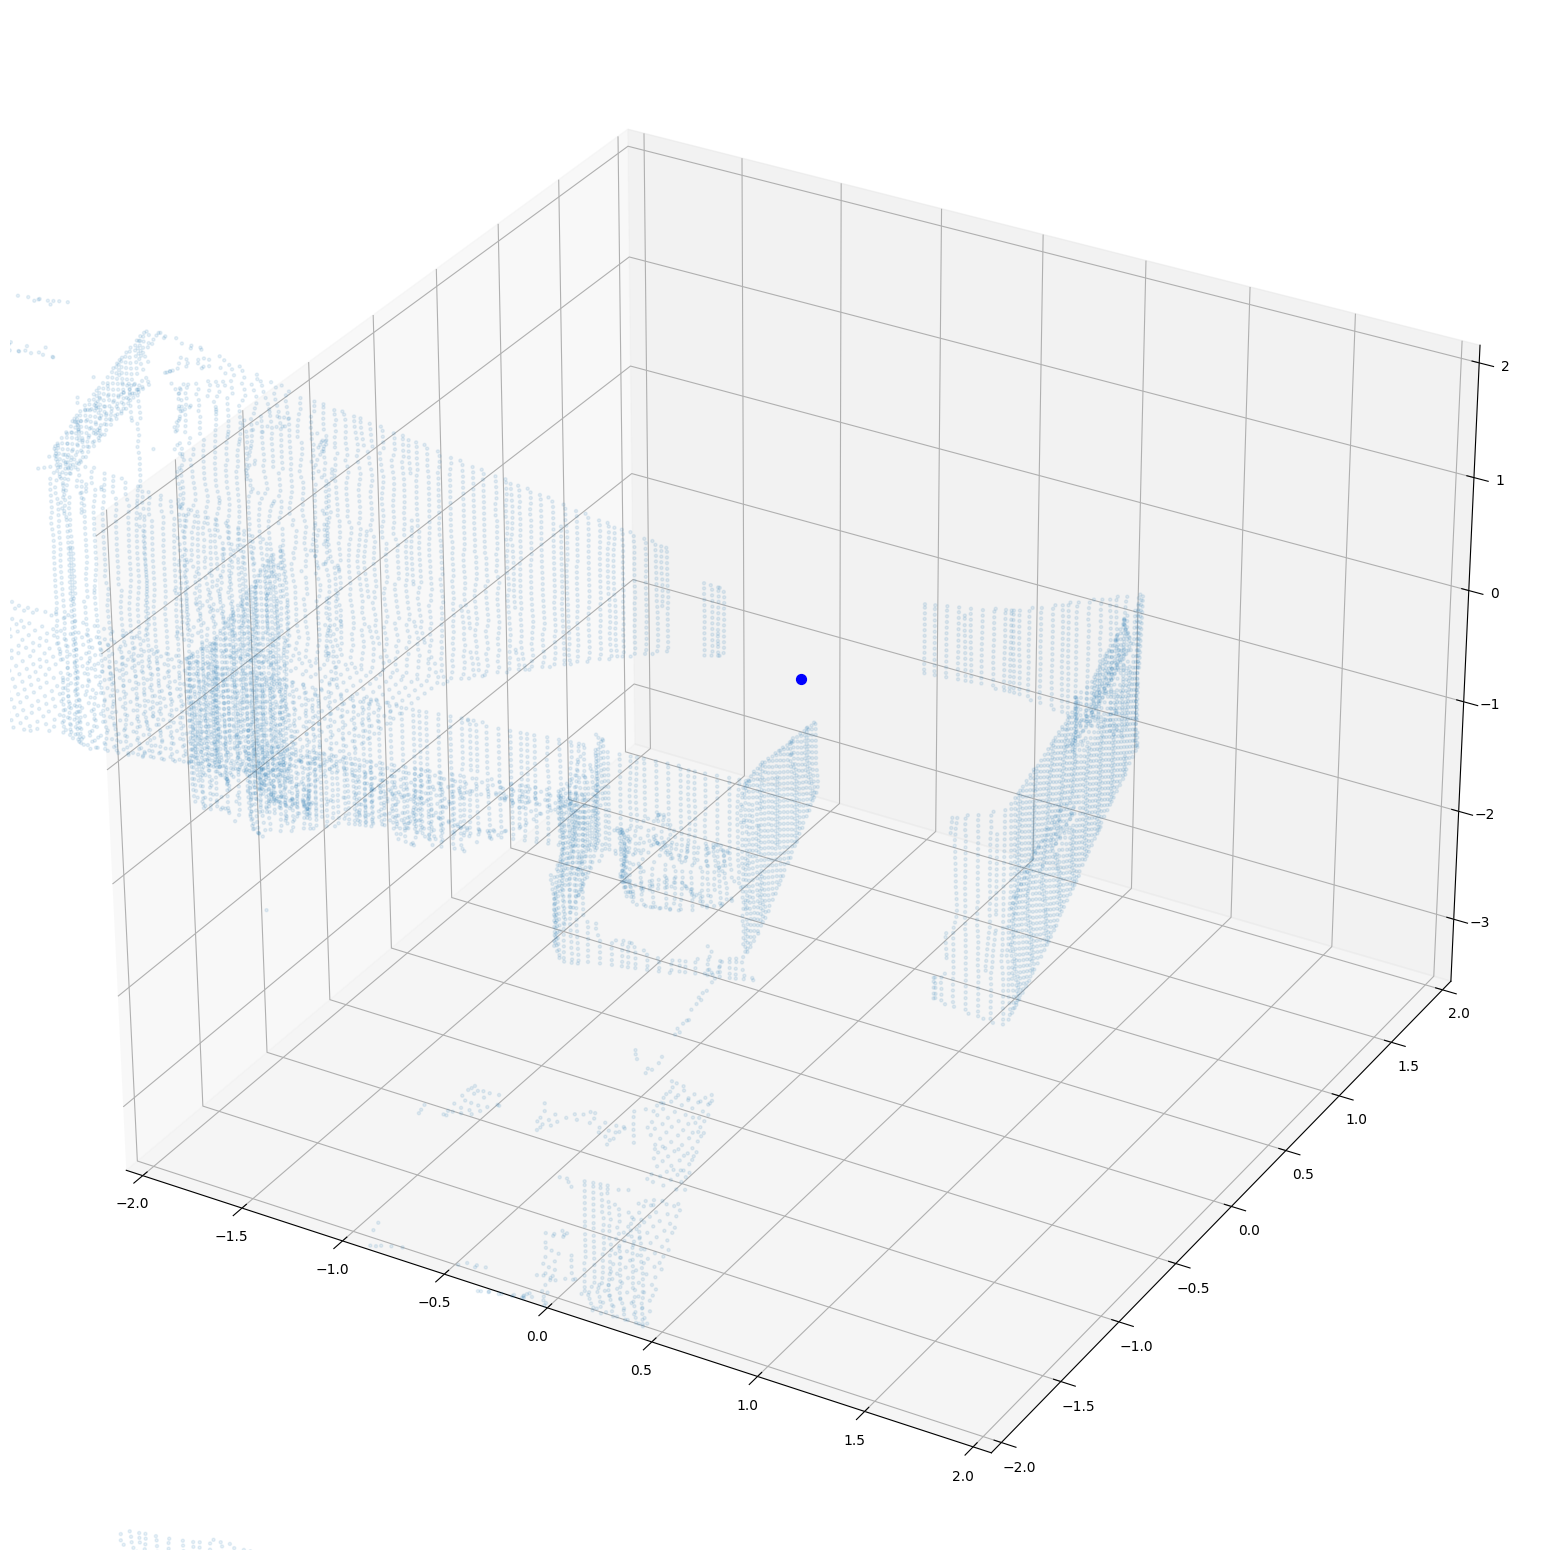

In [30]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(v_cloud[:, 0], v_cloud[:, 1], v_cloud[:, 2], s=5, alpha=0.1)
ax.scatter([0], [0], [0], s=50, color='b')
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))

In [ ]:
#rel_pose = get_rel_pose(*cur_pose, *v_pose)
#rel_pose[0] *= -1
#rel_pose[1] *= -1
cur_cloud_transformed = transform_pcd(cur_cloud, *rel_pose)

In [ ]:
plt.figure(figsize=(12, 12))
plt.scatter(v_cloud[:, 0], v_cloud[:, 1], s=5, alpha=0.3)
plt.scatter(cur_cloud_transformed[:, 0], cur_cloud_transformed[:, 1], s=5, alpha=0.3)

In [183]:
true_pose = [0.5, 0, 0]

In [185]:
def inverse_transform(x, y, theta):
    x_inv = -x * np.cos(theta) - y * np.sin(theta)
    y_inv = x * np.sin(theta) - y * np.cos(theta)
    theta_inv = -theta
    return [x_inv, y_inv, theta_inv]

def apply_pose_shift(pose, rel_x, rel_y, rel_theta):
    x, y, theta = pose
    new_x = x + rel_x * np.cos(-theta) + rel_y * np.sin(-theta)
    new_y = y - rel_x * np.sin(-theta) + rel_y * np.cos(-theta)
    new_theta = theta + rel_theta
    return [new_x, new_y, new_theta]

In [190]:
rel_pose_of_old_vcur = [-0.3730292711231062, -2.532458680041118, -1.7453291109557834]
prev_rel_pose = [-0.3035710692359387, -2.138536224136296, -1.7453300408456578]
rel_pose_prev_to_old = inverse_transform(*prev_rel_pose)
print(rel_pose_prev_to_old)
apply_pose_shift(rel_pose_prev_to_old, *rel_pose_of_old_vcur)

[-2.1587615594835015, -0.07239547856417372, 1.7453300408456578]


[0.39999917884154046, 1.256421067852287e-06, 9.298898744347639e-07]